# Odor spectra in chemical space(s)

### Preperations

#### standard imports

In [1]:
import glob, csv, pickle, os, json, sys
import matplotlib, scipy
import copy

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaders, fcluster
from matplotlib import gridspec
from sklearn.manifold import MDS

#### custom imports

Include the below modules in your PYTHONPATH or directly in the folder of this notebook. 
* `regnmf` is at https://github.com/Huitzilo/FUImaginge
* `bootstrap_prediction` is at https://github.com/Huitzilo/BootstrapPrediction


In [2]:
from regnmf import ImageAnalysisComponents as ia
from bootstrap_prediction import bootstrap_predictor as bp
from bootstrap_prediction import datastructures as ds
# workaround because fspaces.pik (and multivarreg.pik below) was created before 
# refactoring datastructures and bootstrap_predictor into bootstrap_prediction
sys.modules['datastructures'] = ds
sys.modules['bootstrap_predictor'] = bp

#### notebook behavior

In [3]:

#import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 150

#### functions to process hierachichal clustering results (linkages)

In [4]:
def return_all_childs(mylinkage, parent):
    ''' recursive function returns all leaf node indexes below a parent node in mylinkage
    
        parent: node index
        mylinkage = scipy.cluster.hierarchy.linkage result
    '''    
    num_leaves = mylinkage.shape[0]+1
    parent = int(parent)
    if parent<num_leaves:
        return [int(parent)]
    else:
        leftchild, rightchild = mylinkage[parent-num_leaves][:2]
        return return_all_childs(mylinkage, parent=leftchild) + return_all_childs(mylinkage, parent=rightchild)

def return_all_links(mylinkage, parent):
    ''' recursive function returns all nodes below of parent node in mylinkage''' 
    num_leaves = mylinkage.shape[0]+1
    parent = int(parent)
    if parent<num_leaves:
        return [parent]
    else:
        leftchild, rightchild = mylinkage[parent-num_leaves][:2]
        return [parent] + return_all_links(mylinkage, parent=leftchild) + return_all_links(mylinkage, parent=rightchild)

def color_clusters(cluster, color_dict = None):
    ''' creates link-coloring function to color each cluster (given by parent node) '''
    cluster_colors = defaultdict(lambda: '0.5')
    for clust_ix, cluster_parent in enumerate(cluster):
        clust_color = color_dict[cluster_parent] if color_dict else plt.cm.prism(1.*clust_ix/len(cluster)) 
        clust_color = matplotlib.colors.rgb2hex(clust_color)
        colordict_update = {i: clust_color for i in return_all_links(link, cluster_parent+link.shape[0]+1)}
        cluster_colors.update(colordict_update)
    return lambda node: cluster_colors[node]

####  plotting parameter

In [5]:
fig_dim = (7.48,9.4)
global_fs= 7 

layout = {   'axes.labelsize': 7,
             'axes.linewidth': .5, 
             'xtick.major.size': 2,     # major tick size in points
             'xtick.minor.size': 1,     # minor tick size in points
             'xtick.labelsize': 7,       # fontsize of the tick labels
             'xtick.major.pad': 2,  
             
             'ytick.major.size': 2,      # major tick size in points
             'ytick.minor.size': 1,     # minor tick size in points
             'ytick.labelsize':7,       # fontsize of the tick labels
             'ytick.major.pad': 2,
             
             'mathtext.default' : 'regular',
             'legend.fontsize': 7,
             'figure.dpi':150
             }

for k, v in layout.items():
    matplotlib.rcParams[k] = v 

#### data locations

In [6]:
toplevelpath = os.path.realpath(os.path.pardir)
datapath = os.path.join(toplevelpath, 'glomcentric_data_preprocessed')

factorization_path = os.path.join(datapath, 'MOBdecomposed')
bg_path = os.path.join(datapath, 'MOBconverted')
cas2name_file = os.path.join(datapath, 'DataDicts', 'Name2MomCas.tab')
cas2molid_file = os.path.join(datapath, 'ChemBase','odors_dez2013','cas2molid.csv')

## Set analysis parameter

#### Specify parameter

In [7]:
# specify filename speicification of data to use (with wildcard *)
method = 'nnmf_150_sm2_convex_sp*_ios_meas' #'sica_200_ios_meas'
# specify animals to include
animals =  ['111210sph', '111221sph','111222sph', '120107', '120119', '120121', '120125']
# select maximale trial2trial correlation distance (aka 1-correlation) of modes to be included
stimulusdrive = 0.4
# slecet minimal activation strength of modes to be included
min_activation = 0.2
# space in which chemical similarity shall be evaluated
fspace = 'edragon-eva5' # 'haddad' # 

### Load data

#### Function to load and preprocess all measurement data

Final measurement set will pruned to odors only present in all animals

In [8]:
def load_combined_series(allIDs, filemask, thres, min_strength, factorization_path):
    ''' function to load and preprocess timeseries of multiple animals '''
    
    allgood, turn = [], []
    for measID in allIDs:
        
        # load timeseries
        ts = ia.TimeSeries()
        filename = glob.glob(os.path.join(factorization_path, measID, filemask+'.npy'))
        assert len(filename)==1
        ts.load(filename[0].split('.')[0])
        ts.label_stimuli = [i.split('_')[0] for i in ts.label_stimuli]
        
        # if data from left bulb: turn
        if '_l_' in ts.name: 
            turn.append(measID)
            ts.base.set_series(ts.base.shaped2D()[:,::-1])
            
        ts.name = measID
        
        # calc odor spectrum of modes
        signal = ia.TrialMean()(ia.CutOut((2, 5))(ts))        
        # calc t2t correlation, exclude modes with t2t < thres
        mode_cor = ia.CalcStimulusDrive()(signal)
        signal = ia.SelectObjects()(signal, mode_cor._series.squeeze()<thres)
        
        # calc single odor response
        signal = ia.SingleSampleResponse()(signal)
        
        # selected only modes with maximal activation above min_strength
        strength = np.max(signal._series,0)
        signal = ia.SelectObjects()(signal, strength>min_strength)
        
        allgood.append(signal)
        
    allgood = ia.ObjectConcat(unequalsample=True)(allgood)
    return allgood, turn

#### Read in data

In [9]:
featurespaces = pickle.load(open(os.path.join(datapath, 'DataDicts','fspaces.pik')))

cas2molid = {l[0]:l[1] for l in csv.reader(open(cas2molid_file))}
#cas2name = {l[0]:l[1] for l in csv.reader(open(cas2name_file),  delimiter='\t')}
#molid2name = {v:cas2name[k] for k,v in cas2molid.items() if k in cas2name}

ts, turn = load_combined_series(animals, method, stimulusdrive, min_activation, factorization_path)

# load background images, turn if left bulb
bg_dict = {measID: plt.imread(os.path.join(bg_path, measID, 'bg.png')) for measID in animals}
for ani in turn:
    bg_dict[ani] = bg_dict[ani][::-1]

common sample  46
111210sph  reduced from  46
111221sph  reduced from  47
111222sph  reduced from  46
120107  reduced from  46
120119  reduced from  46
120121  reduced from  46
120125  reduced from  52


### Calculate spectral position in chemcial space space

#### Z-score chemical space to make descriptors comparable

In [10]:
feat = copy.deepcopy(featurespaces[fspace])
feat.zscore()

#### Subset data to odors for wich both measurements & descriptors exist

In [11]:
available = np.array([int(cas2molid[i.strip()]) in feat.obj_name for i in ts.label_stimuli])
ts_pruned = ia.SelectTrials()(ts, available)
pos = [feat.obj_name.index(int(cas2molid[i.strip()])) for i in ts_pruned.label_stimuli] 
fspace_data = feat.data[pos]

#### Calculate barycenter of glomeruli in feature space

In [12]:
np.isfinite(fspace_data).all()

True

In [13]:
centers = np.dot(fspace_data.T, ts_pruned._series) / np.sum(ts_pruned._series,0)
ts._series = centers
ts.label_stimuli = featurespaces[fspace].feat_name

# Set origin of feature space in the centrum of measurement data
ts._series = ts._series - np.mean(fspace_data,0).reshape((-1,1))

## Hierachical cluster data

#### Create hierachical clustering of glomerular odor spectra in chemical space

In [14]:
cluster_metric = 'cosine'
linkage_scheme = 'average'

dist = pdist(ts._series.T, metric = cluster_metric)
link = linkage(dist, method = linkage_scheme)

#### Visualize clustering to identify nodes for further analysis

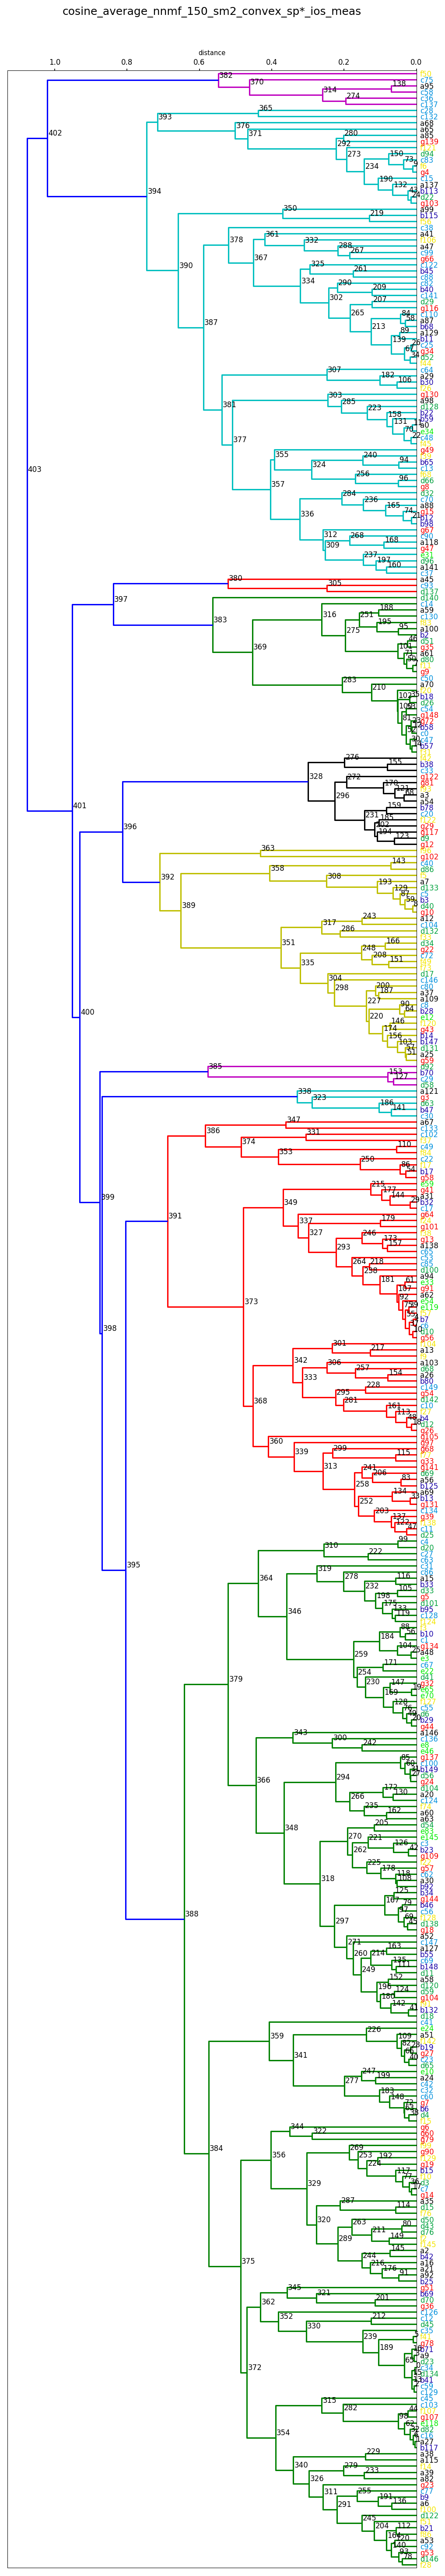

In [15]:
title = '_'.join((cluster_metric, linkage_scheme, method))

# create labels with abbreviations for animals. 
pseudo = dict(zip(animals, 'abcdefghij'))
pseudo['center'] = 'center'
pseudo_inv = {v: k for k, v in pseudo.items()}
new_labels = [pseudo[i.split('_')[0]] + i.split('_mode')[-1] for i in ts.label_objects]
# define color for each animal
animal_colors = [plt.cm.spectral(1.*animals.index(i.split('_')[0])/len(animals)) if i.split('_')[0] in animals else '0.5'
                 for i in ts.label_objects]

# plot hierachical clustering
fig = plt.figure(figsize=(7,len(new_labels)/10.))
ax = fig.add_axes([0.1,0.01,0.89,0.94])
d = dendrogram(link, orientation='left',  count_sort='descending', labels=new_labels)

# label coloring
for l_ind, l in enumerate(ax.yaxis.get_ticklabels()):
    mode = d['leaves'][l_ind]
    l.set_color(animal_colors[mode])
  
# annotate nodes with node id
node_order = list(np.sort(np.array(d['dcoord'])[:,1]))
for di, dd in zip(d['icoord'], d['dcoord']):
    y = 0.5 * sum(di[1:3])
    x = dd[1]
    ix = node_order.index(dd[1])
    ax.annotate("%d" % ix, (x, y), xytext=(1,1), textcoords='offset points', va='bottom', ha='left', size=8)    
   
# decorate axis
ax.set_xlabel('distance')
ax.yaxis.set_tick_params(labelsize=8)
ax.xaxis.set_tick_params(labelsize=8)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_title(title, y=1.02)

### Analysis of clustering in chemical space

#### Functions to create cluster visualization

In [16]:
def plot_location(ts, 
                  link, 
                  cluster, 
                  bg_dict, 
                  ax_dict, 
                  color_dict, 
                  face=True, 
                  base_thres=0.3, 
                  all_glom=False,
                  scalebar=True):
    ''' plot cluster location'''
    
    # plot bg
    for axname,ax in ax_dict.items():
        bg = bg_dict[axname].copy()
        if scalebar:
            pixel_size = 1.63/1344. *1000. #µm
            len_200 = int(round(200./pixel_size))   # 200 µm
            bg[950:970,(300-len_200):300]=1.


        ax.imshow(bg, interpolation='none', cmap=plt.cm.bone, extent=[0,84,64,0])
        ax.set_axis_off()
    
    #plot A-P arrows in the last plot
    scalefac = 1.63/1344.
    ap_arrowcolor = [1.,1.,1.]
    arr1 = ax.arrow(82,60,-8,0, head_width=2.5, color=ap_arrowcolor, linewidth=0.65, zorder=10)
    arr2 = ax.arrow(82,60,0,-8, head_width=2.5, color=ap_arrowcolor, linewidth=0.65, zorder=10)
    arrlabA = ax.text(69,60, 'A', color=ap_arrowcolor, fontsize=6, ha='right', va='center', zorder=10)
    arrlabA = ax.text(81,41, 'L', color=ap_arrowcolor, fontsize=6, ha='center', va='top', zorder=10)
    
    if all_glom:
        for ix in range(ts.num_objects):
            measID = ts.label_objects[ix].split('_')[0]
            mode = ts.base.shaped2D()[ix]    
            ax_dict[measID].contourf(mode, [base_thres,1], colors=['0.5'], alpha=0.5)

    # plot location and timecouses of clusters
    for clust in cluster:    
        color = color_dict[clust]
        spec_collection = []
        for node in return_all_childs(link,clust+link.shape[0]+1):
            # get animal of cluster member
            measID = ts.label_objects[node].split('_')[0]
            # print pixel participation
            mode = ts.base.shaped2D()[node]    
            if face:
                ax_dict[measID].contourf(mode, [base_thres,1], colors=[color], alpha=0.5)
            else:
                ax_dict[measID].contour(mode, [base_thres], colors=[color], alpha=1, linewidths=[2])
                
                

#### Chemical distance to MOR18-2 cluster

calculate mean response of MOR18-2 cluster and it's distance to all other response spectra 

In [17]:
mor182_cluster_id = 98 

protoype_idx = return_all_childs(link, mor182_cluster_id + link.shape[0] + 1)
prototype = np.mean(ts._series[:,protoype_idx],1)
cor = squareform(pdist(np.hstack([prototype[:,np.newaxis], ts._series]).T, cluster_metric))[0,1:]

In [18]:
# automatic selection of cluster
# currently overwritten by manual selection

cluster_parents, _ = leaders(link, fcluster(link, 1.15))
#cluster_parents = cluster_parents - len(d['leaves'])
#cluster = list(cluster[cluster>0])
cluster_parents.shape

thres = 0.5
cluster = []
for parent_node in cluster_parents:
    cluster_idx = return_all_childs(link, parent_node)
    cluster_spec = np.mean(ts._series[:,cluster_idx],1)
    dist2mor182 =  pdist(np.vstack([prototype, cluster_spec]), cluster_metric)[0]
    if dist2mor182 < thres:
        cluster.append(parent_node - link.shape[0] - 1)

### Chemotopic Clustering

In [19]:
fig_dim = (7.48, 4.5)


In [20]:
def plot_hierachical_clusters(fig, gs_meta, cluster, labels=['a','b']):
    #manual selection of cluster
    num_cluster = len(cluster)

    num_animals = len(animals)
    num_stim = len(ts.label_stimuli)
    clust_colors = {clust: plt.cm.gist_rainbow_r(1.*cluster.index(clust)/num_cluster) for clust in cluster}

    gs_top = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 2, gs_meta[0], hspace=0.01, height_ratios=[5,1], 
                                                         wspace=0.05, width_ratios=[16.5,0.3])

    # plot dendrogram
    ax = fig.add_subplot(gs_top[0,0])
    top = gs_meta[0].get_position(fig).corners()[1,1]
    lw = matplotlib.rcParams['lines.linewidth']
    matplotlib.rcParams['lines.linewidth'] = 0.65
    d = dendrogram(link, link_color_func = color_clusters(cluster, clust_colors), count_sort='descending', ax=ax)
    matplotlib.rcParams['lines.linewidth'] = lw
    ax.set_xticks([])
    ax.set_ylabel('$\hat{d}_{cos}$', labelpad=-1)
    ax.set_yticks([0,0.5,1])
    ax.text(-200,1.1,'({})'.format(labels[0]), fontweight='bold', fontsize=global_fs, ha='left', va='center')
    #ax.set_ylim([0,0.2])


    # plot MOR18-2 correlation
    ax = fig.add_subplot(gs_top[1,0])
    im = ax.imshow(((-cor[d['leaves']]+1).reshape((1,-1))), cmap=plt.cm.seismic, #plt.cm.RdYlGn_r, 
                   interpolation='none', 
                   aspect='auto', vmin=-1., vmax=1.)#1.8)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('glomeruli', labelpad=2)
    # colorbar
    axbar = fig.add_subplot(gs_top[:,1])
    cbar = plt.colorbar(im, cax=axbar)
    cbar.set_ticks([-1,0,1])
    cbar.set_label('$cos_{MOR18-2}$', labelpad=-2)

    # plot locations
    gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, num_animals, gs_meta[1,:], wspace=0.02)
    top = gs_meta[1].get_position(fig).corners()[1,1]
    axbase = {animal: fig.add_subplot(gs[0,ix]) for ix, animal in enumerate(animals)}
    plot_location(ts, link, cluster, bg_dict, axbase, clust_colors, base_thres=0.5, all_glom=True)
    axbase[animals[0]].text(-27.5, 1.1, '({})'.format(labels[1]), fontweight='bold', fontsize=global_fs, ha='left', va='center')


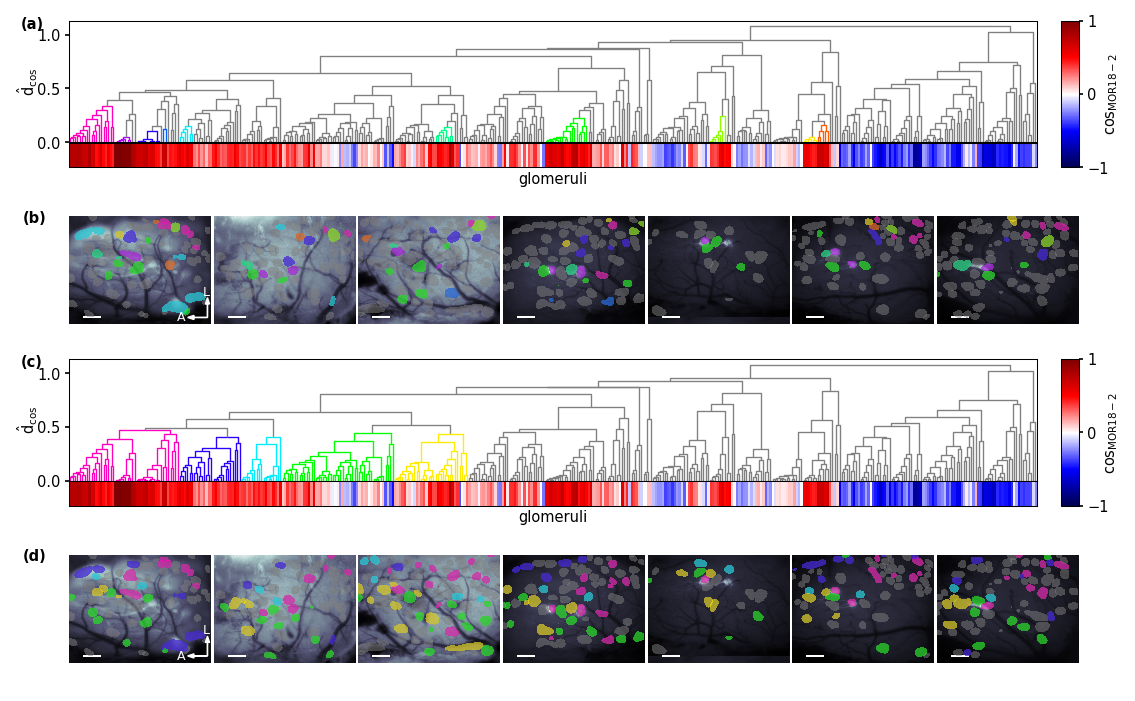

In [21]:
fig = plt.figure(figsize=fig_dim)
gs = matplotlib.gridspec.GridSpec(4, 1, bottom=0.01, top = 0.99, left = 0.05, right=0.95, 
                                       height_ratios=[1, 0.75, 1, 0.75], hspace=0.1)

gs_meta = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1,gs[:2])
cluster = [340, 98, 189, 212, 244, 232, 293, 308, 101, 251]
plot_hierachical_clusters(fig, gs_meta, cluster)

gs_meta = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1,gs[2:])
#cluster = [379, 384]
#cluster = [340, 315, 362, 356, 359, 366, 364]
cluster = [372, 356, 359, 366, 364]
plot_hierachical_clusters(fig, gs_meta, cluster, labels=['c','d'])


In [25]:
fig.savefig(os.path.join(os.path.curdir,'results','chemotopic_clustering.png'), dpi=600)

## Exploring distance vs. similarity, i.e. chemotopy
### Spatial plot of all modes with functional distance to prototype

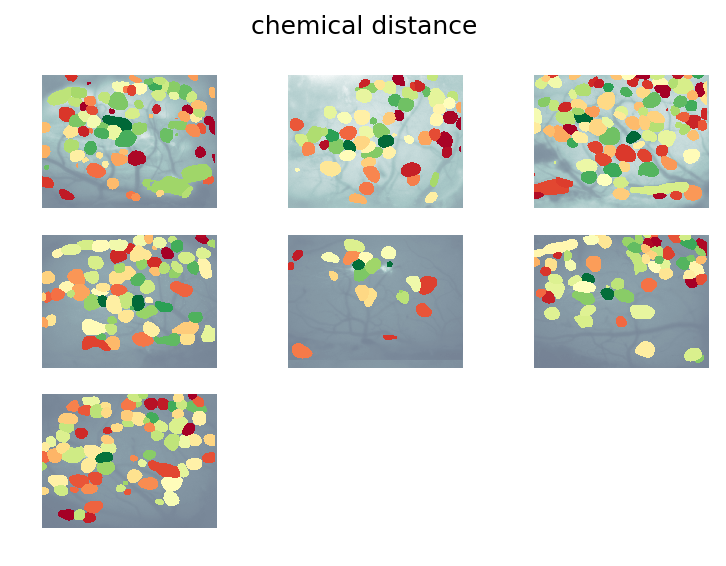

In [22]:
cluster_id = 98
num_animals = len(animals)
fig = plt.figure()
gs = matplotlib.gridspec.GridSpec(3,int(np.ceil(num_animals/3.)))
axbase = [fig.add_subplot(gs[i]) for i in range(num_animals)]


for measID, ax in zip(animals, axbase):
    bg = bg_dict[measID]
    ax.imshow(bg, interpolation='none', cmap=plt.cm.bone, extent=[0,84,64,0], vmin=-1, vmax=1)
    ax.set_axis_off() 

what = ts
for obj_id in range(what.num_objects):
    measID = what.label_objects[obj_id].split('_')[0]
    pos = animals.index(measID)
    base = what.base.shaped2D()[obj_id]
    basecolor = plt.cm.RdYlGn_r(cor[obj_id]/1.5) #if cor[obj_id]<1 else '0.7'
    axbase[pos].contourf(base, [0.3,1], colors=[basecolor]) 
    
fig.suptitle('chemical distance')    
plt.show()

## Distribution of chemical distances for spatial neigbours vs. non-neigbours
### Dilation approach

Cluster modes (putative glomeruli) are iteratively dilated (i.e., expanded by 1 pixel). The number of dilation iteration required until two modes overlap with at least one pixel is then the neighborhood function. Few dilations = close neighbors, many dilations = distant neighbors.

 distance neighbours: 0.39, nonneighbours: 0.87, p_values -> MWU: 0.0256, KS: 0.0376, T: 0.0776
 distance neighbours: 0.74, nonneighbours: 0.89, p_values -> MWU: 0.0024, KS: 0.0053, T: 0.0031
 distance neighbours: 0.81, nonneighbours: 0.90, p_values -> MWU: 0.0261, KS: 0.0255, T: 0.0244
 distance neighbours: 0.84, nonneighbours: 0.91, p_values -> MWU: 0.0956, KS: 0.0145, T: 0.0745


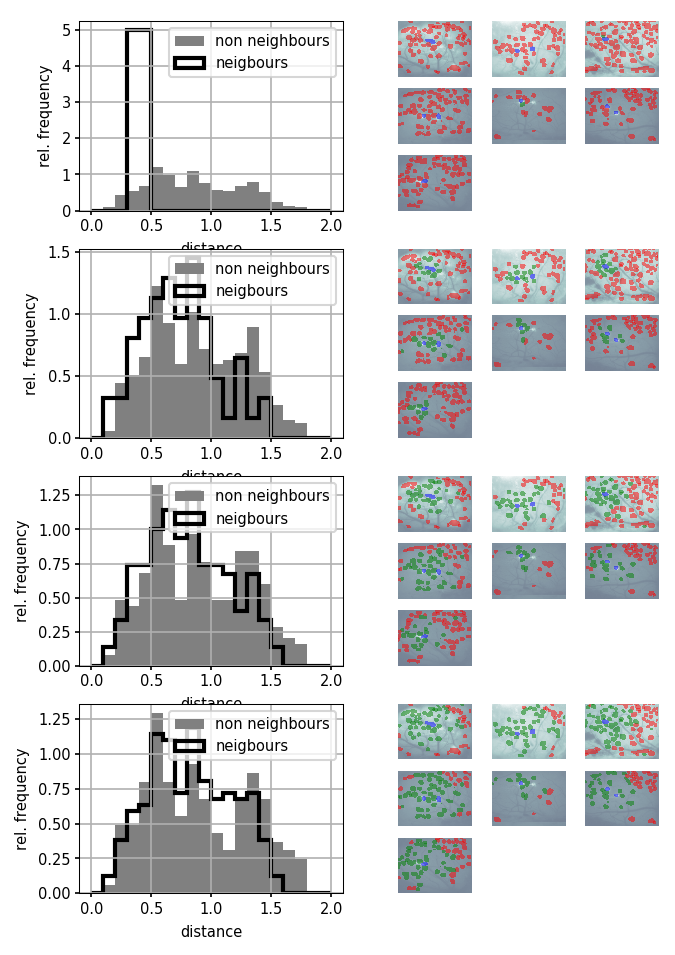

In [23]:
f = plt.figure(figsize=(5,70))
gs = matplotlib.gridspec.GridSpec(35,2)
matplotlib.rcParams['savefig.dpi'] = 150

for idx,dilation in enumerate(range(1, 35, 10)): # [6]: 

    thres = 0.6
    metric='cosine'
    show = True
    
    # get cluster member
    member_idx = return_all_childs(link,cluster_id+link.shape[0]+1)
    member_mask = np.zeros(ts.num_objects).astype('bool')
    member_mask[member_idx] = True
    
    
    # calculate which modes overlap with cluster modes
    neighbour_modes = np.zeros(ts.num_objects).astype('bool')
    nbpixels = {}
    for animal in animals:
        animal_mask = np.array([animal in mode for mode in ts.label_objects])
        neighbour_pixel = np.logical_or(ts.base.shaped2D()[animal_mask*member_mask]>thres,0).squeeze()
        if dilation: #might be able to replace dilation with findpeaks and radial extension, a bit cleaner
            neighbour_pixel = scipy.ndimage.morphology.binary_dilation(neighbour_pixel, iterations=dilation)
        #nbpixels[animal] = neighbour_pixel
        neighbour_modes[animal_mask] = np.max(ts.base._series[animal_mask][:,neighbour_pixel.flatten()],1)>thres
    neighbour_modes[member_mask]=False    
    
    # calculate mode distances
    prototype = np.mean(ts._series[:,member_idx],1)
    dist = squareform(pdist(np.hstack([prototype[:,np.newaxis], ts._series]).T, metric))[0,1:]
    dist_neighbours = dist[neighbour_modes]
    dist_nonneighbours = dist[~(neighbour_modes+member_mask)]
    
    if show:
        # plot distance distribution
        ax = f.add_subplot(plt.Subplot(f, gs[idx,0]))
        ax.hist(dist_nonneighbours, np.linspace(0,2,21), color=['0.5'], normed=True, lw=0, rwidth=1, label='non neighbours')
        ax.hist(dist_neighbours, np.linspace(0,2,21), color='k', normed=True, histtype='step', lw=2, rwidth=1, label= 'neigbours')
        ax.set_xlabel('distance')
        ax.set_ylabel('rel. frequency')
        ax.grid()
        plt.legend()
        
        # plot neighbour modes
        #fig = plt.figure()
        gs_glom = matplotlib.gridspec.GridSpecFromSubplotSpec(3,int(np.ceil(num_animals/3.)),gs[idx,1])
        axbase = [f.add_subplot(plt.Subplot(f, gs_glom[i])) for i in range(num_animals)]
        
        
        for measID, ax in zip(animals, axbase):
            bg = bg_dict[measID]
            ax.imshow(bg, interpolation='none', cmap=plt.cm.bone, extent=[0,84,64,0], vmin=-1, vmax=1)
            ax.set_axis_off() 
        
        for obj_id in range(what.num_objects):
            measID = what.label_objects[obj_id].split('_')[0]
            pos = animals.index(measID)
            base = what.base.shaped2D()[obj_id]
            basecolor ='g' if neighbour_modes[obj_id] else ('b' if member_mask[obj_id] else 'r')
            axbase[pos].contourf(base, [thres,1], colors=[basecolor], alpha=0.5) # if cor[obj_id]<1 else (1.,0.1,0.1)], alpha=0.9)
            #axbase[pos].imshow(nbpixels[measID], alpha=0.3, cmap=plt.cm.bone)
        
        
    # calculate significance of distribution difference
    _, p_mwu = scipy.stats.mannwhitneyu(dist_neighbours, dist_nonneighbours)
    _, p_ks = scipy.stats.ks_2samp(dist_neighbours, dist_nonneighbours)
    _, p_tt = scipy.stats.ttest_ind(dist_neighbours, dist_nonneighbours)
    print ' distance neighbours: %.2f, nonneighbours: %.2f, p_values -> MWU: %.4f, KS: %.4f, T: %.4f'%(np.mean(dist_neighbours),np.mean(dist_nonneighbours), p_mwu, p_ks, p_tt)

### Approach via distance of mode maxima

Neighborhood between two modes is is determined by the euclidean distance of their peaks. If their are putative glomeruli in a mode, each glomerulus peak is considered separately.

In [24]:
from skimage.feature import peak_local_max
from itertools import compress

In [25]:
# get cluster member
# "members" are modes that cluster together with the MOL23 GFP landmark
mol23_cluster = 98
member_idx = return_all_childs(link,mol23_cluster+link.shape[0]+1)
member_mask = np.zeros(ts.num_objects).astype('bool')
member_mask[member_idx] = True 

# find peaks in modes
mode_thresh = 0.6
min_d = 4
peaks = []
for i in range(ts.base.shaped2D().shape[0]):
    peaks.append(peak_local_max(ts.base.shaped2D()[i,:,:], 
                                threshold_abs=mode_thresh, 
                                min_distance=min_d))

##### Visualisation of peaks, parameter determination
Parameters for peak detection were determined manually such that there should preferably be only one peak per glomerulus, and weak glomeruli should be ignored; boiling down to the following criteria:
* check for multiple peak artefacts in a single glomerulus; control via `min_distance` (final value: 4)
* check sensitivity, avoid noise artefacts but still catch all glomeruli; control via `threshold_abs` (final value: 0.7)

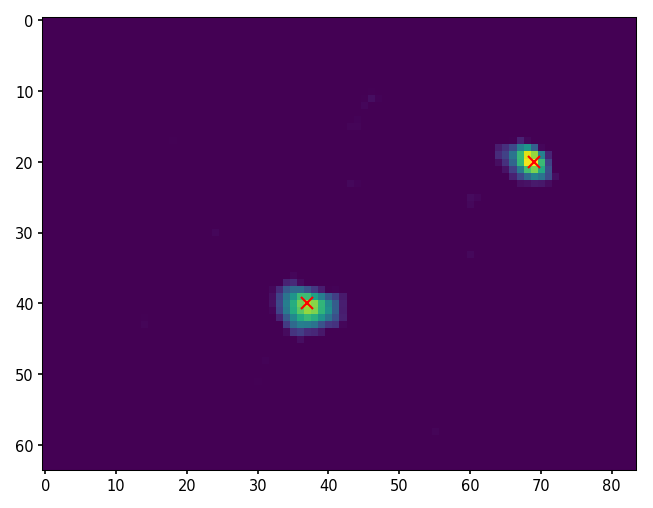

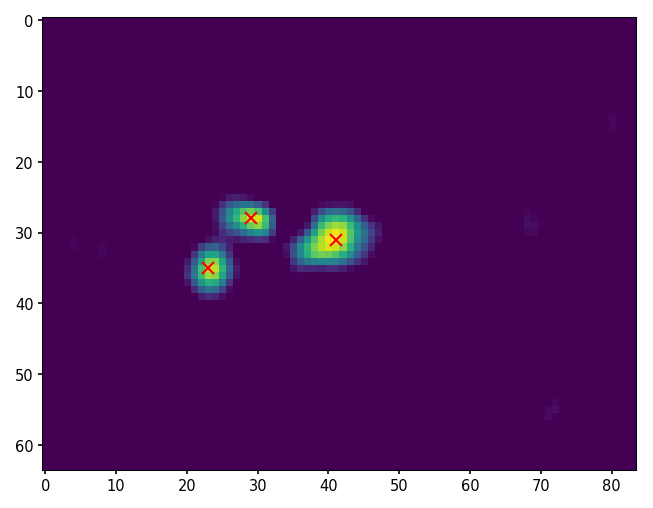

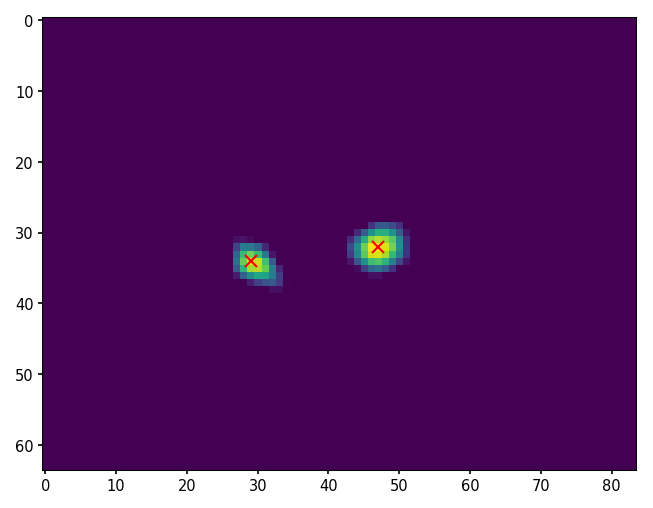

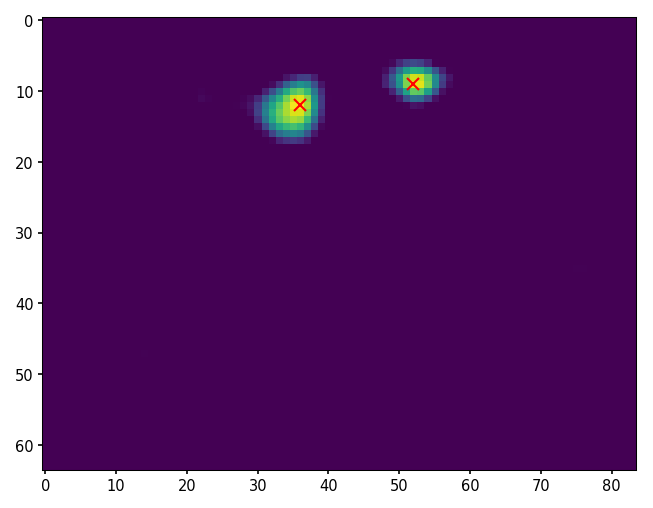

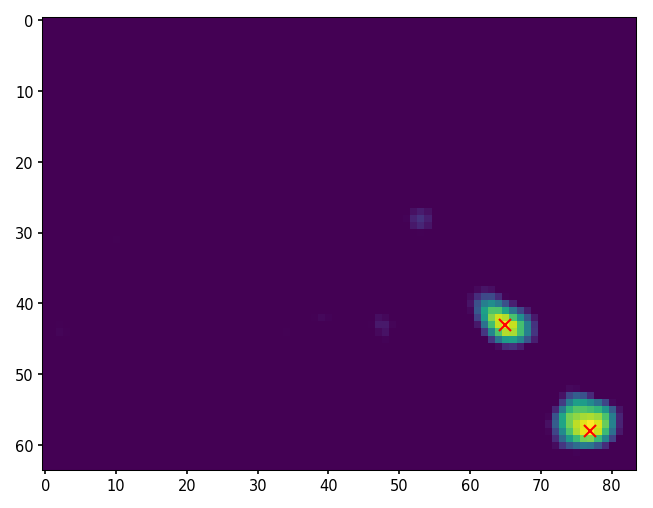

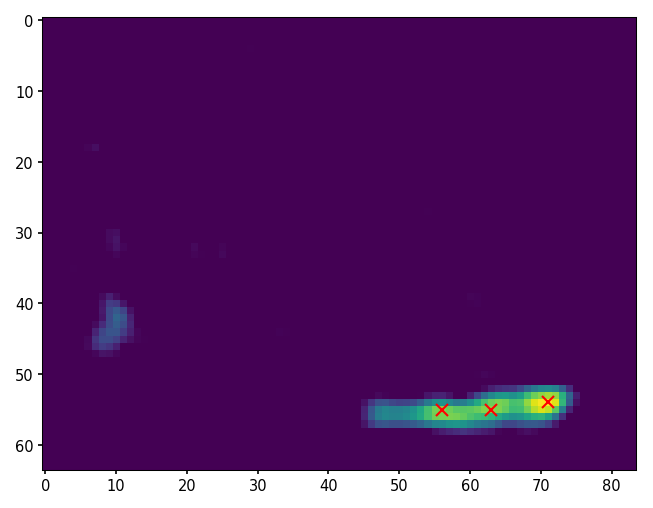

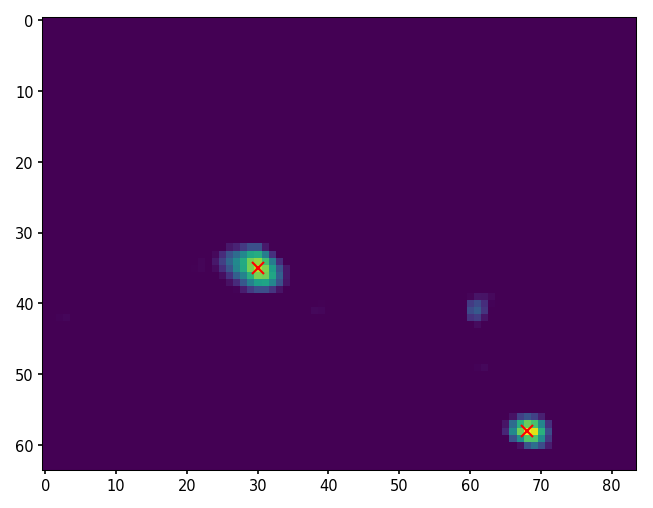

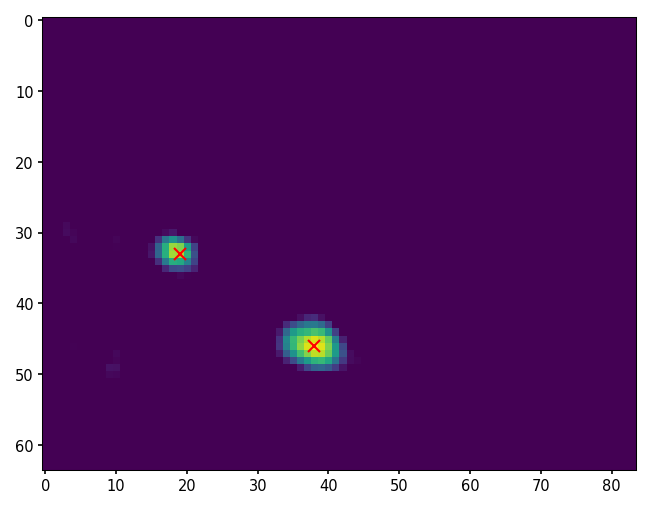

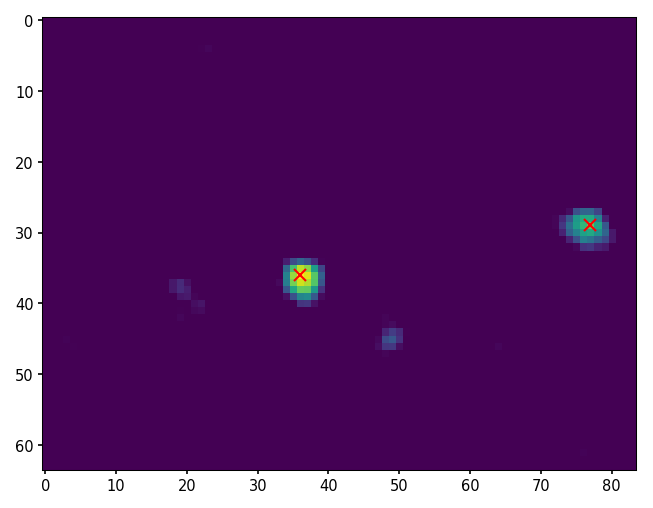

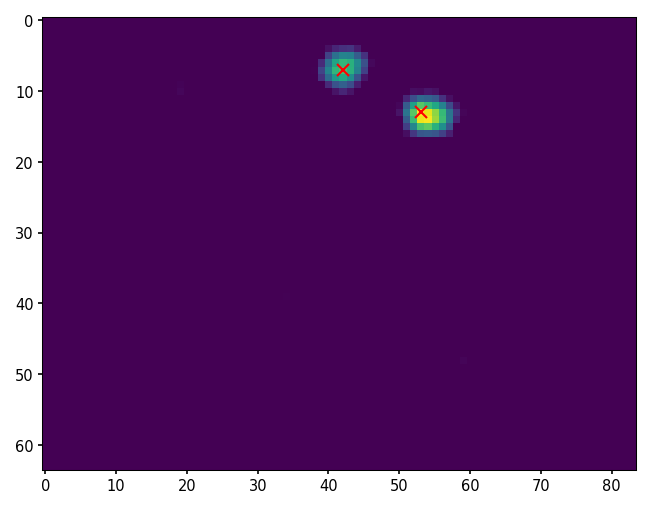

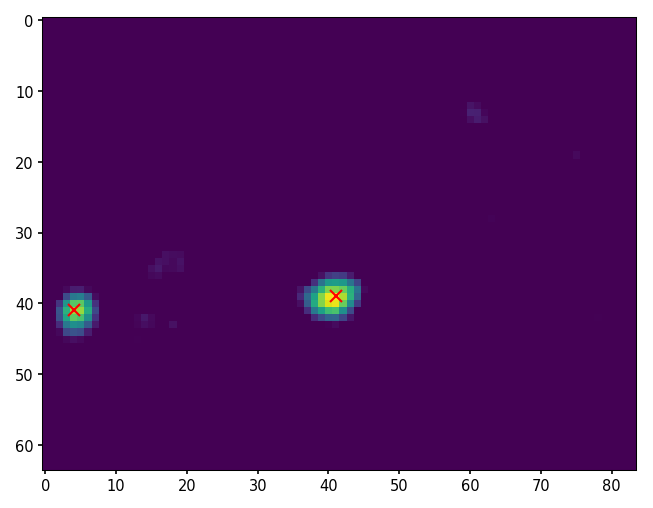

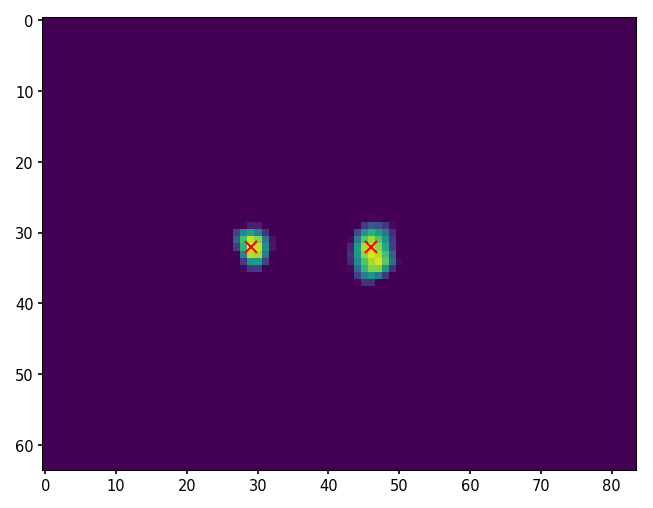

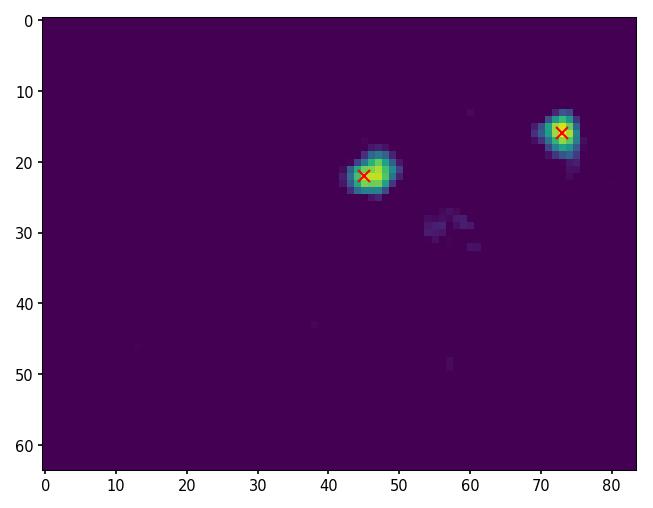

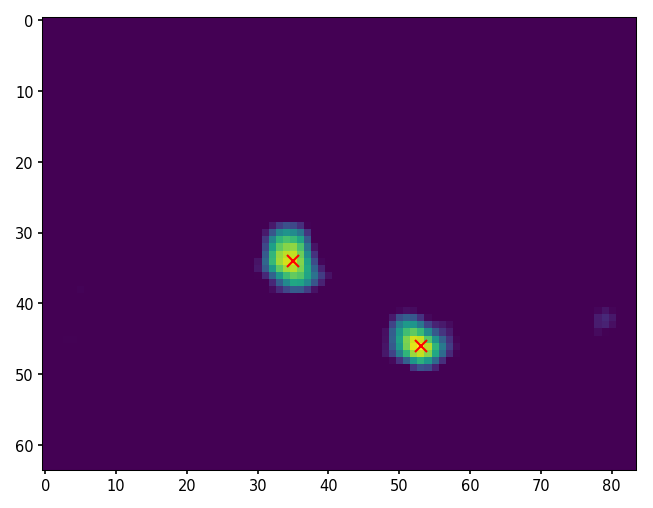

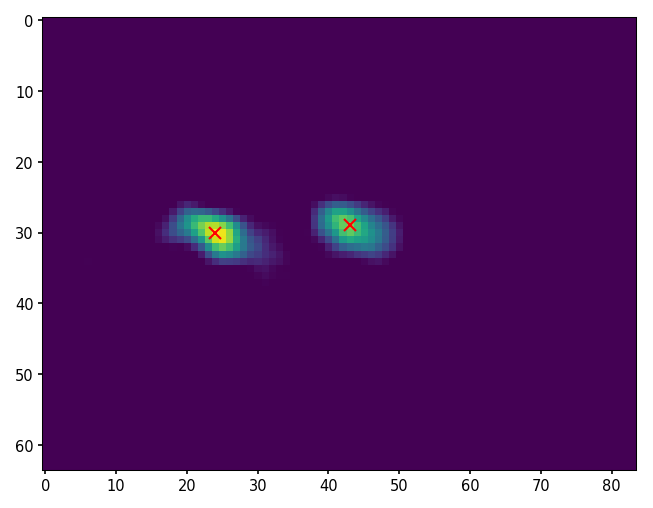

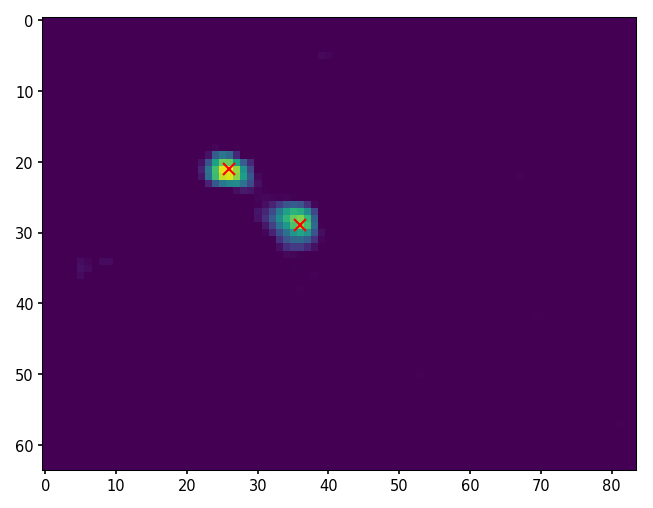

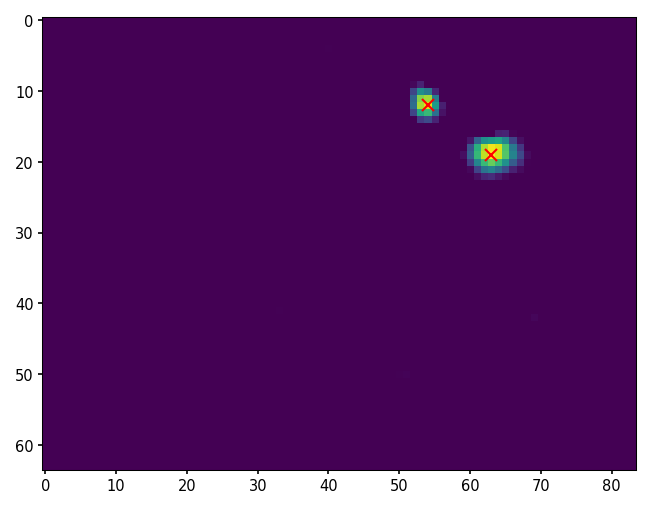

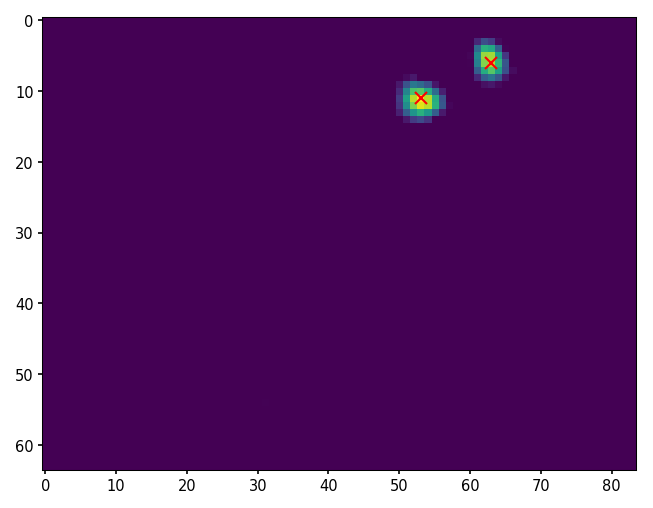

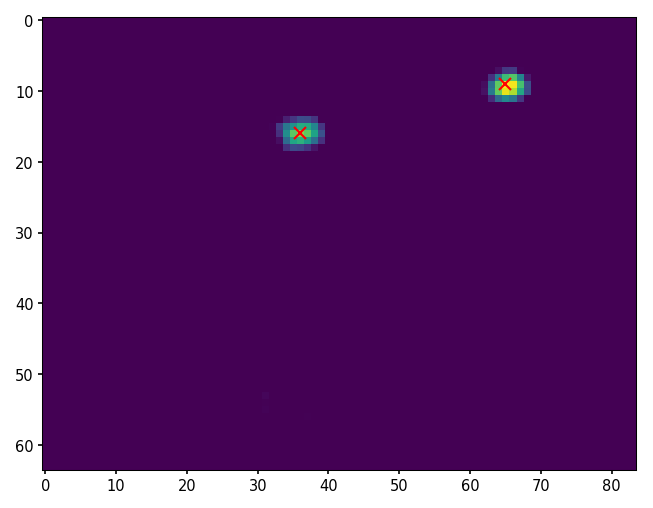

In [26]:
peaks = []
for i in range(ts.base.shaped2D().shape[0]):
    peaks.append(peak_local_max(ts.base.shaped2D()[i,:,:], threshold_abs=0.7, min_distance=4))
for i,peak in enumerate(peaks):
    if len(peak) >1:
        f = plt.figure()
        ax = f.add_subplot(111)
        ax.imshow(ts.base.shaped2D()[i,:,:])
        for p in peak:
            ax.plot(p[1], p[0], 'rx')

##### Calculate pairs of pixel distance and chemical distance.

In [27]:
pixd_chemd = []
for animal in animals:
    animal_mask = np.array([animal in mode for mode in ts.label_objects])
    amembers = np.logical_and(animal_mask,member_mask) #"members" are MOR18.2 modes
    anonmembers = np.logical_and(animal_mask,~member_mask)
    member_peaks = list(compress(peaks, amembers))
    non_member_peaks = list(compress(peaks, anonmembers))
    
    
    member_series = ts._series[:,amembers]
    nonmember_series = ts._series[:, anonmembers]

    # calculate mode distances
    chemdists = squareform(pdist(np.hstack([ts._series[:,amembers], 
                                            ts._series[:,anonmembers]]).T, 
                                 metric='cosine'))[0, 1:] #just the first row, just the non-members
    
    for mps in member_peaks: #double indexing required because findpeaks returns 2D array
        for mp in mps:
            for i,nmps in enumerate(non_member_peaks):
                chemd = chemdists[i]
                if len(nmps) < 1:
                    d = [np.nan, chemd]
                else:
                    for nmp in nmps:
                        d = np.linalg.norm(nmp-mp)
                        #dists.append(d)
                        #print("mp: {} nmp:{} nmp-mp:{} dist:{}".format(mp, nmp, nmp-mp, dist))
                        pixd_chemd.append([d, chemd])

##### Plot spatial distance vs. chemical distance

correlation coefficient: 0.080


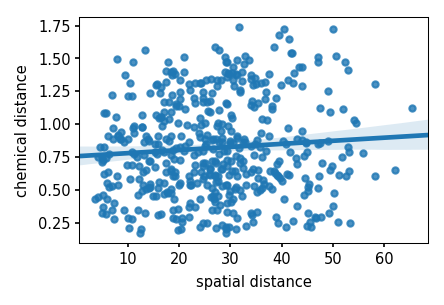

In [28]:
pcd = np.array(pixd_chemd)
cc = np.corrcoef(pcd.T)[0,1]
print("correlation coefficient: {:.3f}".format(cc))

import seaborn as sns
f = plt.figure(figsize=(3,2))
ax = f.add_subplot(111)
sns.regplot(x=pcd[:,0], y=pcd[:,1], ax=ax, marker='.')
ax.set_xlabel("spatial distance")
ax.set_ylabel("chemical distance")



There is essentially no discernible correlation between peak distance and chemical distance. However, there are uncertainties in the data concerning the relation between chemical and spatial distance. 

Spatial distance meares are reasonably accurate, their uncertainty depends only on the precision of the peak detection. 

Chemical distances are subject to several uncertainties. The location of a receptive field in chemical space is determined as a point (i.e., centroid). Computing the euclidean distance between receptive field centroids in chemical space assumes that their shape is isotropic. This is almost certainly not the case. In order to estimate the *actual* extent of the chemical receptive field, and hence distance to other receptive fields, these fields would need to be sampled at a reasonably high density. Our study focused on MOR18.2, and our odorant choice was optimised to determine its receptive field. Therefore, receptive fields of glomeruli with receptive fields less similar to the one of MOR18.2 will be less well sampled. 

Undersampling of the receptive field will lead to errors in the estimation of chemical distance. Since the centroids of receptive fields are calculated as the barycentre of all activations in feature space, those glomeruli with few activations (due to unsersampling) will be located close to the origin, biasing the distance calculation. Moreover, the presence or absence of very few odorants in the dataset can change the picture dramatically for undersampled receptive fields. These two factors could explain the high noise and low correlation between chemical and spatial distance. 

##### pairwise peak distances vs. chemical distances

We therefore pursued an alternative approach to assess the relation between spatial and chemical distance that is less sensitive to noise. First we partitioned the modes into two populations, spatial neighbors and non-neighbors of MOR18.2. Then we compared the distances between pairs of neighbors, and pairs of neighbors and non-neighbors (Fig. below).

Panel plan:
 - a) peak radii and glomeruli in one animal
 - b) histograms for the distances in all animals
 - c) average distance, including bar indicating KS p-value like in Fig. 2 (maybe log?)
 - d) randommised spatial distance (smaller than c, but with KS)
 - e) randomised chemical distance (dito)

In [47]:
def init_explore_plot(num_plots):
    f = plt.figure(figsize=(8,num_plots*3.5))
    gs = matplotlib.gridspec.GridSpec(num_plots,2)
    matplotlib.rcParams['savefig.dpi'] = 150
    matplotlib.rcParams['figure.dpi'] = 150
    return f, gs

def plot_bg(ax, measID, bg_dict):
    bg = bg_dict[measID]
    ax.imshow(bg, interpolation='none', cmap=plt.cm.bone, extent=[0,84,64,0], vmin=-1, vmax=1)
    ax.set_axis_off() 
    

def plot_dist_histograms(ax, neighbor_dists, nonneighbor_dists, decor=True):
    ax.hist(nonneighbor_dists, np.linspace(0,2,41), 
        color=['0.5'], 
        normed=True, 
        cumulative=True,
        lw=0, 
        rwidth=1, 
        label='non neighbours')
    ax.hist(neighbor_dists, 
        np.linspace(0,2,41), 
        color='k', 
        normed=True, 
        cumulative=True,
        histtype='step', 
        lw=1, 
        rwidth=1, 
        label='neighbours')
    yticks = ax.get_yticks()
    ax.set_yticks([yticks[0], yticks[-1]])
    ax.set_yticklabels(["{:.1f}".format(yticks[0]), "{:.1f}".format(yticks[1])])
    ax.set_frame_on(False)
    if decor:
        ax.set_xlabel('chem. distance')
        ax.set_ylabel('rel. frequency')
        plt.legend()

    
def plot_single_hist_with_all_animals(f, 
                                      gs, 
                                      current_plot_row, 
                                      nonneighbor_dists, 
                                      neighbor_dists, 
                                      animals, 
                                      bg_dict,
                                      what,
                                      neighbor_animal_mask,
                                      member_mask):
    gssub = matplotlib.gridspec.GridSpecFromSubplotSpec(4, 4, gs[current_plot_row,0])
    ax1 = plt.subplot(gssub[0,0])
    ax2 = plt.subplot(gssub[0,1])
    ax3 = plt.subplot(gssub[0,2])
    ax4 = plt.subplot(gssub[0,3])
    ax5 = plt.subplot(gssub[1,3])
    ax6 = plt.subplot(gssub[2,3])
    ax7 = plt.subplot(gssub[3,3])
    ax_h = plt.subplot(gssub[1:,:3])


    # plot distance histogram
   #ax_h = f.add_subplot(plt.Subplot(f, gs[current_plot_row,0]))
    plot_dist_histograms(ax_h, neighbor_dists, nonneighbor_dists, legend=True)

    #gs_glom = matplotlib.gridspec.GridSpecFromSubplotSpec(3,int(np.ceil(num_animals/3.)),gs[current_plot_row,1])
    #axbase = [f.add_subplot(plt.Subplot(f, gs_glom[i])) for i in range(num_animals)]
    axbase = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]

    for measID, ax in zip(animals, axbase):
        plot_bg(ax, measID, bg_dict)

    for obj_id in range(what.num_objects):
        measID = what.label_objects[obj_id].split('_')[0]
        pos = animals.index(measID)
        base = what.base.shaped2D()[obj_id]
        basecolor ='g' if neighbor_animal_mask[measID][obj_id] else ('b' if member_mask[obj_id] else 'r')
        axbase[pos].contourf(base, [thres,1], colors=[basecolor], alpha=0.5) # if cor[obj_id]<1 else (1.,0.1,0.1)], alpha=0.9)
        #axbase[pos].imshow(nbpixels[measID], alpha=0.3, cmap=plt.cm.bone)

def init_pub_plot(num_plots, figsize=(13,9)):
    matplotlib.rcParams['savefig.dpi'] = 150
    matplotlib.rcParams['figure.dpi'] = 150
    matplotlib.rcParams['svg.fonttype'] = 'none'
    f = plt.figure(figsize=figsize)
    gs = matplotlib.gridspec.GridSpec(num_plots, 3, width_ratios=[1,1.2,4], hspace=0.7)
    return f, gs
    
def plot_pub_fig(f, 
                 gs,
                 current_plot_step, 
                 nonneighbor_dists, 
                 neighbor_dists, 
                 animals, 
                 bg_dict,
                 what,
                 neighbor_animal_mask,
                 member_mask,
                 cur_dist,
                 animal_to_plot=0):
    #panel a: modes and neighbors
    ax = f.add_subplot(gs[current_plot_step, 0])
    measID = animals[animal_to_plot]
    plot_bg(ax, measID, bg_dict)
    for obj_id in range(what.num_objects):
        curr_measID = what.label_objects[obj_id].split('_')[0]
        if curr_measID != measID:
            continue
        base = what.base.shaped2D()[obj_id]
        basecolor ='g' if neighbor_animal_mask[measID][obj_id] else ('b' if member_mask[obj_id] else 'r')
        ax.contourf(base, [thres,1], colors=[basecolor], alpha=0.5)
    ax.set_title("$r_{{metric}} = {:.2f}\mu m$".format(cur_dist), fontsize=8)
    #panel b: histograms
    ax = f.add_subplot(gs[current_plot_step, 1])
    plot_dist_histograms(ax, 
                         neighbor_dists, 
                         nonneighbor_dists, 
                         decor=current_plot_step == gs.get_geometry()[0]-1)
    
    
def chemotopyfun(figtype='explore', animal_to_plot=1, printstats=False, figsize=(13,9)):
    """
    figtype: "explore" or "publication"
    """
    global ts
    global member_mask
    global what
    
    pixel_size = 8 * 1.63/1344. *1000. #µm
    
    metric = 'cosine'
    
    show_at_dists = np.array([50., 100., 150., 200., 250, 300.]) #µm
    max_dist = 301. #µm
    min_dist = 40. #µm 
    dist_step = 10. #µm

    steps = np.arange(min_dist,max_dist,dist_step)
    num_plots = len(show_at_dists)
    current_plot_step = 0
    
    if figtype=='explore':
        f, gs = init_explore_plot(num_plots)
    else:
        f, gs = init_pub_plot(num_plots, figsize=figsize)
    
    nd = [] #neighbor dists for all steps
    nnd = [] #non-neighbor dists for all steps
    
    datadicts = [] #stores all results

    for d_idx,d_thresh in enumerate(steps):
        neighbor_dists = np.array([])
        nonneighbor_dists = np.array([])
        neighbor_animal_mask = {}
        nonneighbor_animal_mask = {}
        for animal in animals:
            animal_mask = np.array([animal in mode for mode in ts.label_objects])
            amembers = np.logical_and(animal_mask,member_mask)
            anonmembers = np.logical_and(animal_mask,~member_mask)
            member_peaks = list(compress(peaks, amembers))
            non_member_peaks = list(compress(peaks, anonmembers))

            anonmembers_list = np.nonzero(anonmembers)[0]
            neighbors = []

            for mps in member_peaks: #double indexing required because findpeaks returns 2D array
                for mp in mps:
                    for i,nmps in enumerate(non_member_peaks):
                        is_neigh = False
                        for nmp in nmps:
                            d = np.linalg.norm(nmp-mp)
                            d *= pixel_size
                            is_neigh = is_neigh or (d < d_thresh)
                        if is_neigh:
                            neighbors.append(anonmembers_list[i])
            neighbor_mask = np.zeros_like(anonmembers)
            neighbor_mask[neighbors] = True
            nonneighbor_mask = np.logical_and(anonmembers, ~neighbor_mask) 
            neighbor_animal_mask[animal] = neighbor_mask
            nonneighbor_animal_mask[animal] = nonneighbor_mask
            for member_idx in np.nonzero(amembers)[0]:
                prototype = np.mean(ts._series[:,amembers], axis=1)
                neigh_dists = squareform(pdist(np.hstack([prototype[:,np.newaxis], 
                                                          ts._series[:,neighbor_mask]]).T, 
                                               metric))[0,1:]
                nonneigh_dists = squareform(pdist(np.hstack([prototype[:,np.newaxis], 
                                                             ts._series[:,nonneighbor_mask]]).T, 
                                                  metric))[0,1:]
                neighbor_dists = np.concatenate((neighbor_dists, neigh_dists))
                nonneighbor_dists = np.concatenate((nonneighbor_dists, nonneigh_dists))

            # calculate significane of distribution difference
        v_mwu, p_mwu = scipy.stats.mannwhitneyu(neighbor_dists, nonneighbor_dists)
        v_ks, p_ks = scipy.stats.ks_2samp(neighbor_dists, nonneighbor_dists)
        v_tt, p_tt = scipy.stats.ttest_ind(neighbor_dists, nonneighbor_dists)
        datadict = {"d_thresh": d_thresh,
                          "neighbor_dists": neighbor_dists,
                          "nonneighbor_dists": nonneighbor_dists,
                          "KSstat": [v_ks, p_ks],
                          "MWUstat": [v_mwu/(len(neighbor_dists)*len(nonneighbor_dists)), p_mwu],
                          "TTstat": [v_tt, p_tt]}
        datadicts.append(datadict)
        
        if printstats:
            print("""%.2f distance limit
            distance neighbours/non-neighbors: %.3f / %.3f
            p_values: KS: %.5f (p=%.5f) – MWU p=%.5f – TT p=%.5f"""%(d_thresh,
                            np.mean(neighbor_dists),
                            np.mean(nonneighbor_dists), 
                            v_ks, p_ks, 
                            p_mwu, 
                            p_tt))
        
        nd.append(neighbor_dists)
        nnd.append(nonneighbor_dists)

        if np.min(np.abs(show_at_dists - d_thresh))<0.2:
            if figtype == 'explore':
                plot_single_hist_with_all_animals(f, 
                                  gs, 
                                  current_plot_step, 
                                  nonneighbor_dists, 
                                  neighbor_dists, 
                                  animals, 
                                  bg_dict,
                                  what,
                                  neighbor_animal_mask,
                                  member_mask)
            elif figtype == 'pub':
                plot_pub_fig(f,
                             gs, 
                             current_plot_step, 
                             nonneighbor_dists, 
                             neighbor_dists, 
                             animals, 
                             bg_dict,
                             what,
                             neighbor_animal_mask,
                             member_mask,
                             d_thresh,
                             animal_to_plot)
            else:
                print("unknown figure type {}".format(figtype))
            current_plot_step += 1
            
    if figtype == 'pub': #plot distances vs. threshold
        ax = f.add_subplot(gs[:, 2:])
        ax.plot([d['d_thresh'] for d in datadicts], 
        1.-np.array([np.mean(d['neighbor_dists']) for d in datadicts]), 
        label="neighbours",
        color='g')
        ax.plot([d['d_thresh'] for d in datadicts], 
                1.-np.array([np.mean(d['nonneighbor_dists']) for d in datadicts]), 
                label="non-neighbours",
                color='r')
        ax1 = ax.twinx()
        ax1.plot([d['d_thresh'] for d in datadicts], 
#                [d['KSstat'][0] for d in datadicts], 
                [d['MWUstat'][1] for d in datadicts], 
                label="p_MWU", lw=0.5)
        ax.set_xlabel(u'neighbourhood radius [µm]')
        ax.set_ylabel('average chemical similarity to MOR18-2')
        ax1.set_ylabel("p_MW")
        ax.set_ylim(0,0.63)
        ax.legend()
        ax1.legend()
        ax.set_frame_on(False)
        ax1.set_frame_on(False)



    return datadicts, plt.gcf()

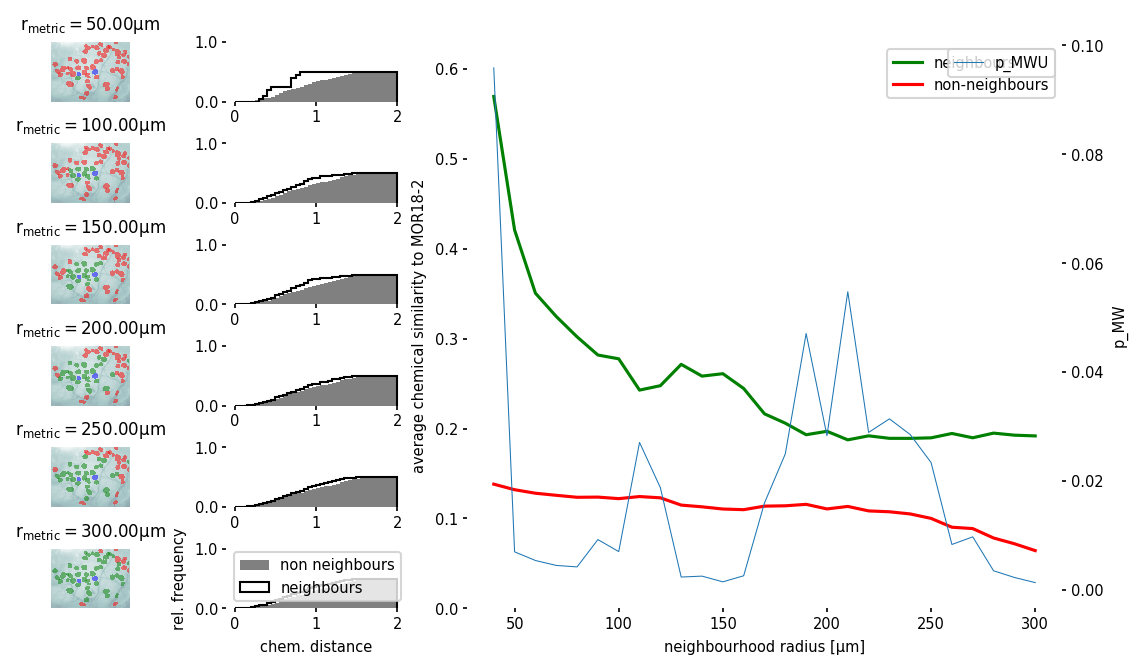

In [48]:
datadicts,f = chemotopyfun(figtype='pub', animal_to_plot=1, figsize=(9,5), printstats=False)

In [44]:
f.savefig("clustering.svg")

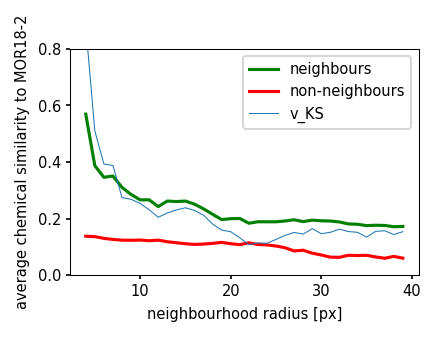

In [76]:
f = plt.figure(figsize=(3,2))
ax = plt.gca()
ax.plot([d['d_thresh'] for d in datadicts], 
        1.-np.array([np.mean(d['neighbor_dists']) for d in datadicts]), 
        label="neighbours",
        color='g')
ax.plot([d['d_thresh'] for d in datadicts], 
        1.-np.array([np.mean(d['nonneighbor_dists']) for d in datadicts]), 
        label="non-neighbours",
        color='r')
ax.plot([d['d_thresh'] for d in datadicts], 
        [d['KSstat'][0] for d in datadicts], 
        label="v_KS", lw=0.5)

ax.set_xlabel('neighbourhood radius [px]')
ax.set_ylabel('average chemical similarity to MOR18-2')
ax.set_ylim(0,0.8)
ax.legend()

#### Randomised control
##### a) randomise chemical profile
The chemical profiles of the mode are randomly shuffled.

In [113]:
metric = 'cosine'
show_at_dists = [5., 7., 10., 19., 27., 33.]
max_dist = 40.
min_dist = 5.
dist_step = 1.

steps = np.arange(min_dist,max_dist,dist_step)
num_plots = len(show_at_dists)
current_plot_row = 0

f = plt.figure(figsize=(8,num_plots*3.5))
gs = matplotlib.gridspec.GridSpec(num_plots,2)
matplotlib.rcParams['savefig.dpi'] = 150
matplotlib.rcParams['figure.dpi'] = 150

nd = [] #neighbor dists for all steps
nnd = [] #non-neighbor dists for all steps

for d_idx,d_thresh in enumerate(steps):
    neighbor_dists = np.array([])
    nonneighbor_dists = np.array([])
    neighbor_animal_mask = {}
    nonneighbor_animal_mask = {}
    for animal in animals:
        animal_mask = np.array([animal in mode for mode in ts.label_objects])
        amembers = np.logical_and(animal_mask,member_mask)
        anonmembers = np.logical_and(animal_mask,~member_mask)
        member_peaks = list(compress(peaks, amembers))
        non_member_peaks = list(compress(peaks, anonmembers))

        anonmembers_list = np.nonzero(anonmembers)[0]
        neighbors = []
        
        for mps in member_peaks: #double indexing required because findpeaks returns 2D array
            for mp in mps:
                for i,nmps in enumerate(non_member_peaks):
                    is_neigh = False
                    for nmp in nmps:
                        d = np.linalg.norm(nmp-mp)
                        is_neigh = is_neigh or (d < d_thresh)
                    if is_neigh:
                        neighbors.append(anonmembers_list[i])
        neighbor_mask = np.zeros_like(anonmembers)
        neighbor_mask[neighbors] = True
        nonneighbor_mask = np.logical_and(anonmembers, ~neighbor_mask) 
        neighbor_animal_mask[animal] = neighbor_mask
        nonneighbor_animal_mask[animal] = nonneighbor_mask
        #ts permutation, randomising the time series, i.e. the chemical response spectrum
        np.random.seed(123456798)
        ts_permut = ts.copy()
        tempts = ts_permut._series[:, animal_mask]
        tempts = tempts[:,np.random.permutation(np.sum(animal_mask))]
        for perm_ind, a_ind in enumerate(np.nonzero(animal_mask)[0]):
            ts_permut._series[:,a_ind] = tempts[:, perm_ind]
        
        for member_idx in np.nonzero(amembers)[0]:
            prototype = np.mean(ts_permut._series[:,amembers], axis=1)
            neigh_dists = squareform(pdist(np.hstack([prototype[:,np.newaxis], 
                                                      ts_permut._series[:,neighbor_mask]]).T, 
                                           metric))[0,1:]
            nonneigh_dists = squareform(pdist(np.hstack([prototype[:,np.newaxis], 
                                                         ts_permut._series[:,nonneighbor_mask]]).T, 
                                              metric))[0,1:]
            neighbor_dists = np.concatenate((neighbor_dists, neigh_dists))
            nonneighbor_dists = np.concatenate((nonneighbor_dists, nonneigh_dists))
    print("neighbor_dists: {:3f}, nonneighbor_dists: {:.3f}".format(np.mean(neighbor_dists), 
                                                                    np.mean(nonneighbor_dists)))
    
    nd.append(neighbor_dists)
    nnd.append(nonneighbor_dists)
 

neighbor_dists: 0.872959, nonneighbor_dists: 0.792
neighbor_dists: 0.798242, nonneighbor_dists: 0.793
neighbor_dists: 0.793748, nonneighbor_dists: 0.793
neighbor_dists: 0.754813, nonneighbor_dists: 0.797
neighbor_dists: 0.783632, nonneighbor_dists: 0.794
neighbor_dists: 0.822460, nonneighbor_dists: 0.790
neighbor_dists: 0.812288, nonneighbor_dists: 0.791
neighbor_dists: 0.795623, nonneighbor_dists: 0.793
neighbor_dists: 0.775854, nonneighbor_dists: 0.796
neighbor_dists: 0.797916, nonneighbor_dists: 0.792
neighbor_dists: 0.829403, nonneighbor_dists: 0.785
neighbor_dists: 0.813955, nonneighbor_dists: 0.788
neighbor_dists: 0.814346, nonneighbor_dists: 0.787
neighbor_dists: 0.799058, nonneighbor_dists: 0.791
neighbor_dists: 0.800334, nonneighbor_dists: 0.790
neighbor_dists: 0.801532, nonneighbor_dists: 0.789
neighbor_dists: 0.802155, nonneighbor_dists: 0.789
neighbor_dists: 0.797168, nonneighbor_dists: 0.791
neighbor_dists: 0.788725, nonneighbor_dists: 0.796
neighbor_dists: 0.783000, nonne

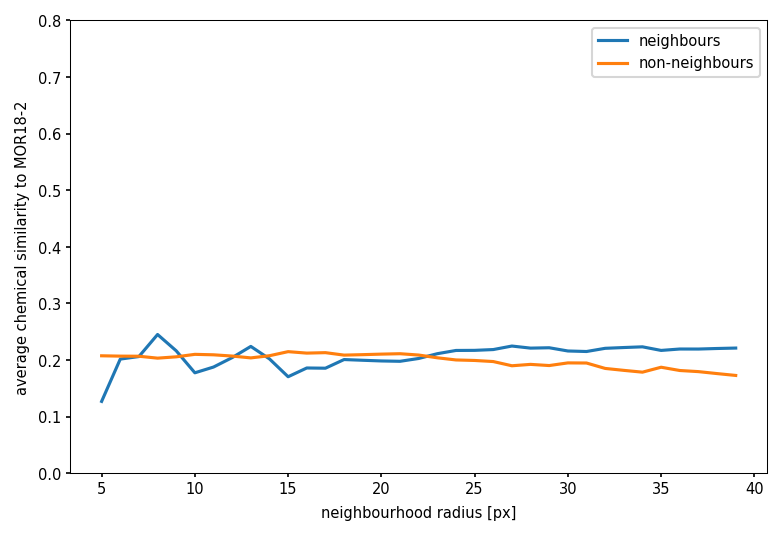

In [114]:
ax = plt.gca()
ax.plot(steps, 1.-np.array([np.mean(d) for d in nd]), label="neighbours")
ax.plot(steps, 1.-np.array([np.mean(d) for d in nnd]), label="non-neighbours")
ax.set_xlabel('neighbourhood radius [px]')
ax.set_ylabel('average chemical similarity to MOR18-2')
ax.set_ylim(0,0.8)
ax.legend()

#### b) randomise spatial distance
Distances between modes are shuffled, chemical profiles remain.

In [115]:
from itertools import chain

In [128]:
metric = 'cosine'
show_at_dists = [5., 7., 10., 19., 27., 33.]
max_dist = 40.
min_dist = 5.
dist_step = 1.

steps = np.arange(min_dist,max_dist,dist_step)
num_plots = len(show_at_dists)
current_plot_row = 0

f = plt.figure(figsize=(8,num_plots*3.5))
gs = matplotlib.gridspec.GridSpec(num_plots,2)
matplotlib.rcParams['savefig.dpi'] = 150
matplotlib.rcParams['figure.dpi'] = 150

nd = [] #neighbor dists for all steps
nnd = [] #non-neighbor dists for all steps

for d_idx,d_thresh in enumerate(steps):
    neighbor_dists = np.array([])
    nonneighbor_dists = np.array([])
    neighbor_animal_mask = {}
    nonneighbor_animal_mask = {}
    for animal in animals:
        animal_mask = np.array([animal in mode for mode in ts.label_objects])
        amembers = np.logical_and(animal_mask,member_mask)
        anonmembers = np.logical_and(animal_mask,~member_mask)
        member_peaks = list(compress(peaks, amembers))
        non_member_peaks = list(compress(peaks, anonmembers))
        #peaks permutation
        peaks_perm = [m for m in chain(member_peaks,non_member_peaks)]
        np.random.seed(3487898)
        peaks_perm = np.random.permutation(peaks_perm)
        member_peaks_perm = peaks_perm[:len(member_peaks)]
        non_member_peaks_perm = peaks_perm[len(member_peaks):]
        
        anonmembers_list = np.nonzero(anonmembers)[0]
        neighbors = []
        
        for mps in member_peaks_perm: #double indexing required because findpeaks returns 2D array
            for mp in mps:
                for i,nmps in enumerate(non_member_peaks_perm):
                    is_neigh = False
                    for nmp in nmps:
                        d = np.linalg.norm(nmp-mp)
                        is_neigh = is_neigh or (d < d_thresh)
                    if is_neigh:
                        neighbors.append(anonmembers_list[i])
        neighbor_mask = np.zeros_like(anonmembers)
        neighbor_mask[neighbors] = True
        nonneighbor_mask = np.logical_and(anonmembers, ~neighbor_mask) 
        neighbor_animal_mask[animal] = neighbor_mask
        nonneighbor_animal_mask[animal] = nonneighbor_mask

        for member_idx in np.nonzero(amembers)[0]:
            prototype = np.mean(ts._series[:,amembers], axis=1)
            neigh_dists = squareform(pdist(np.hstack([prototype[:,np.newaxis], 
                                                      ts._series[:,neighbor_mask]]).T, 
                                           metric))[0,1:]
            nonneigh_dists = squareform(pdist(np.hstack([prototype[:,np.newaxis], 
                                                         ts._series[:,nonneighbor_mask]]).T, 
                                              metric))[0,1:]
            neighbor_dists = np.concatenate((neighbor_dists, neigh_dists))
            nonneighbor_dists = np.concatenate((nonneighbor_dists, nonneigh_dists))
    print("neighbor_dists: {:3f}, nonneighbor_dists: {:.3f}".format(np.mean(neighbor_dists), 
                                                                    np.mean(nonneighbor_dists)))
    
    nd.append(neighbor_dists)
    nnd.append(nonneighbor_dists)
 

neighbor_dists: 0.792832, nonneighbor_dists: 0.861
neighbor_dists: 0.842208, nonneighbor_dists: 0.861
neighbor_dists: 0.909879, nonneighbor_dists: 0.859
neighbor_dists: 0.908338, nonneighbor_dists: 0.859
neighbor_dists: 0.925273, nonneighbor_dists: 0.857
neighbor_dists: 0.911946, nonneighbor_dists: 0.857
neighbor_dists: 0.889469, nonneighbor_dists: 0.859
neighbor_dists: 0.906021, nonneighbor_dists: 0.857
neighbor_dists: 0.896835, nonneighbor_dists: 0.857
neighbor_dists: 0.885689, nonneighbor_dists: 0.858
neighbor_dists: 0.894867, nonneighbor_dists: 0.856
neighbor_dists: 0.903130, nonneighbor_dists: 0.855
neighbor_dists: 0.900398, nonneighbor_dists: 0.854
neighbor_dists: 0.919131, nonneighbor_dists: 0.850
neighbor_dists: 0.918065, nonneighbor_dists: 0.849
neighbor_dists: 0.894371, nonneighbor_dists: 0.853
neighbor_dists: 0.878559, nonneighbor_dists: 0.856
neighbor_dists: 0.884541, nonneighbor_dists: 0.854
neighbor_dists: 0.861111, nonneighbor_dists: 0.861
neighbor_dists: 0.850798, nonne

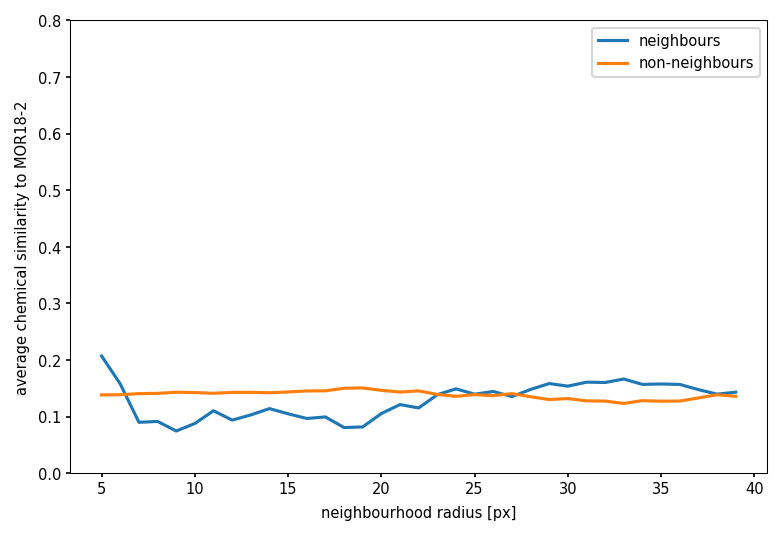

In [129]:
ax = plt.gca()
ax.plot(steps, 1.-np.array([np.mean(d) for d in nd]), label="neighbours")
ax.plot(steps, 1.-np.array([np.mean(d) for d in nnd]), label="non-neighbours")
ax.set_xlabel('neighbourhood radius [px]')
ax.set_ylabel('average chemical similarity to MOR18-2')
ax.set_ylim(0,0.8)
ax.legend()